In [1]:
%pylab inline
import geopandas as gpd
import pandas as pd
import os
import mplleaflet

# in_data_dir = '/Users/datateam/Desktop/SASAP/Mining'
# out_data_dir = '/Users/datateam/Desktop/SASAP/HabMetricsOut/'
# 
# infp = lambda s: os.path.join(in_data_dir, s)
# outfp = lambda s: os.path.join(out_data_dir, s)

Populating the interactive namespace from numpy and matplotlib


# Regions

Importing shapefiles for mining footprints and regional data.

In [2]:
mines_fp = 'Mining/Mining_Disturbance_All.shp'
mines = gpd.read_file(mines_fp)
regions_fp = 'HUC8_rebuild/output/sasap_regions.shp'
regions = gpd.read_file(regions_fp)

# Mining

I want to attribute regions and watersheds with data on mining footprints, defined as areas of disturbed land and impacts from mining activities.

I'll subset regions and watersheds by the following data:
* Number of mining footprints (mining impact areas) intersecting each region or watershed.
* Average area of those mining footprints.
* Area (km<sup>2</sup>) impacted by mining within regional and watershed boundaries (area clipped to regional or watershed boundaries).
* Density of mining areas defined as ($\frac{mining\,footprint\,area}{regional\,or\,watershed\,area}$).

Checking out the mining data. It looks like there are 646 digitized mining footprints.

In [4]:
# mines.info()
mines.head(2)
# mines.head(1) I don't understand why this doesn't work but oh well


,Shape_Leng,Shape_Area,Fprint_SqK,NWB_LCC,AK,geometry
0,1334.351335,1.124019e+05,0.112402,0.0,1.0,"POLYGON ((1377265.215299999 772470.9927999992,..."
1,28456.598509,5.919031e+06,5.919031,0.0,1.0,POLYGON ((-441174.9189999998 1017629.655400001...


And checking out the region data. Regions are identified by the `region` attribute, so that'll be our key.

In [5]:
regions.info()
regions.head(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
region_id    13 non-null int64
region       13 non-null object
geometry     13 non-null object
dtypes: int64(1), object(2)
memory usage: 392.0+ bytes


,region_id,region,geometry
0,1,Aleutian Islands,(POLYGON ((-1156665.959195634 420855.093106978...
1,2,Arctic,"POLYGON ((571289.9424044372 2143072.479559347,..."
2,3,Bristol Bay,(POLYGON ((-339688.5870041371 973904.876117813...


Before running any analysis, I'll make sure both `regions` and `mines` data are in the Alaska Albers projection ([epsg:3338](http://spatialreference.org/ref/epsg/3338/)).

In [3]:
mines = mines.to_crs(epsg=3338)
regions = regions.to_crs(epsg=3338)

# Count of Mining Footprints

To count mining footprints for each region, I'll first create an intersection dataframe showing mine polygons as `True` or `False` for intersection with regional geometries.

Now, I can sum up all of those mine polygons that evaluate as `True` for regional intersection. I'll attribute that count to the `region` DataFrame.

In [4]:
m_intersect = {} # dict
for i, r in regions.iterrows():
    _id, region, r_geo = r # unpack r it has 3 elements, this could actually be just r[-1] because we only need the last element (actually we need region so it's better to leave it that way)
    for j, m in mines.iterrows():
        m_geo = m[-1] # what's this? the last element ... iterow returns tuple with index location and series (row in this case that is actually a column with a sum?)
        # me[-1] returns the last value (or last element) works on list or series - in this case it could also just be m['geometry']
        if r_geo.intersects(m_geo): # double for loop everything is regions and mines will be compared
            if region not in m_intersect.keys(): # what is keys?, so .keys() is just calling the keys (dicts have keys and values) d = {'marie': 31, 'david': 34}, marie and david are keys
                m_intersect[region] = [m_geo]
            else:
                m_intersect[region].append(m_geo)

Let's check out the map. It looks like the Yukon region, the largest region, has the most mines (by far) at 391.

KeyError: 'm_intersect'

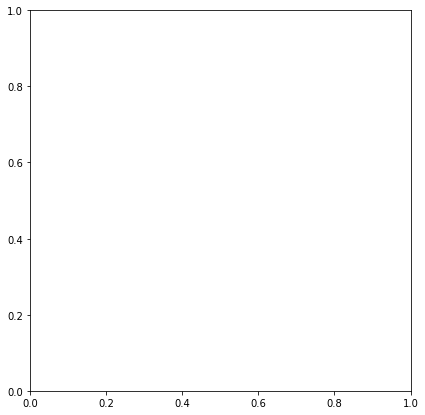

In [7]:
fig, ax = subplots(1,1,figsize=(7,7))
ax = mines.plot(column='m_intersect', cmap='Oranges', ax=ax, linewidth=0.4)
ax.set_axis_off()
foo = ax.axes.set_aspect('equal')

In [15]:
regions.sort_values(by='n_mines', ascending=False).head(3)

,region_id,region,geometry,n_mines
12,13,Yukon,POLYGON ((-375317.9778843221 1473997.623078777...,391.0
9,10,Norton Sound,(POLYGON ((-848356.9600070229 1636692.01922057...,70.0
11,12,Southeast,(POLYGON ((1287776.763303712 744574.0859671872...,44.0


# Average Area of Mining Footprints

I'll look at the `Shape_Area` attribute of those mining footprints we counted above to find the average area of footprints intersecting each region. Since I'm interested in the characteristics of the mining footprints, I won't clip mining area to regional boundaries.

In [16]:
for reg in regions.region:
    mines_reg = mines[mines[reg]]
    avg_m_area = mines_reg.Shape_Area.mean() * 1e-6
    regions.loc[regions.region==reg, 'avg_m_area'] = avg_m_area

Converting `NaN` values to 0 for those regions without any intersecting mines.

In [17]:
regions['avg_m_area'] = regions['avg_m_area'].fillna(0)

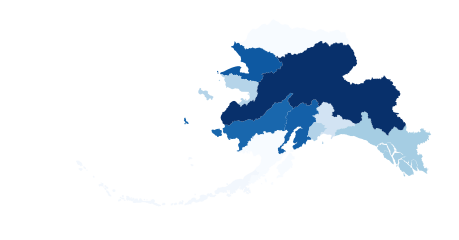

In [18]:
fig, ax = subplots(1,1,figsize=(7,7))
ax = regions.plot(column='avg_m_area', cmap='Blues', ax=ax, linewidth=0.4)
ax.set_axis_off()
foo = ax.axes.set_aspect('equal')

# Area per Region and Density of Mining Footprints

Now, I'm interested in mining data specific to each region:
* Area of each region covered by mining footprints and 
* Density, defined as ($\frac{mining\,footprint\,area}{regional\,area}$).

For these analyses, I'll have to union mining polygons and clip the resulting shape to regional boundaries. From there, I can evaluate the area of each region covered by mining activity.

In [19]:
for reg in regions.region:
    mines_reg = mines[mines[reg]]
    mines_union = mines_reg.unary_union
    regions_union = regions.query("region==@reg").unary_union
    mines_reg_clip = mines_union.intersection(regions_union)
    regions.loc[regions.region==reg, 'area_mines'] = mines_reg_clip.area * 1e-6

Now, it's one more quick step to find density using the `area_mines` attribute from the previous analysis.

In [20]:
regions['density_mines'] = regions.area_mines/(regions.area * 1e-6)

In [21]:
regions.sort_values(by='density_mines', ascending = False).head()

,region_id,region,geometry,n_mines,avg_m_area,area_mines,density_mines
12,13,Yukon,POLYGON ((-375317.9778843221 1473997.623078777...,391.0,2.212924,864.999527,0.001003
9,10,Norton Sound,(POLYGON ((-848356.9600070229 1636692.01922057...,70.0,0.670258,45.939046,0.000687
8,9,Cook Inlet,"(POLYGON ((35214.97605528703 1002456.87086566,...",24.0,1.804829,51.127322,0.000450
7,8,Kuskokwim,(POLYGON ((-1030125.203115781 1281198.22296843...,26.0,1.743793,45.338615,0.000276
6,7,Kotzebue,(POLYGON ((-678815.2871972915 1819518.97119244...,17.0,1.862390,26.074320,0.000199


Let's map this out. It looks like even though the Yukon region is very large, it also has the highest density of mining impact areas.

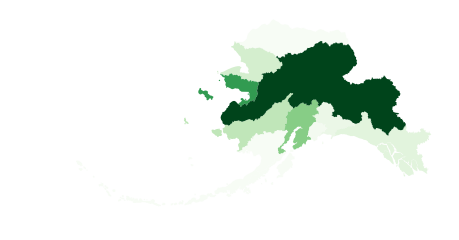

In [22]:
fig, ax = subplots(1,1,figsize=(7,7))
ax = regions.plot(column='density_mines', cmap='Greens', ax=ax, linewidth=0.4)
ax.set_axis_off()
foo = ax.axes.set_aspect('equal')

Export the results to shapefile and csv formats. I need to drop the "geometry" field in order to export to csv.

In [23]:
regions.to_file(outfp('Regions_with_Mines.shp'))
regions.drop('geometry', axis='columns').to_csv(outfp('Regions_with_Mines.csv'))

# Watersheds

I'm going to run the same analysis as above, but for watersheds. To reiterate, these attributes are:
* Number of mining footprints (mining impact areas) intersecting each watershed.
* Average area of those mining footprints.
* Area (km<sup>2</sup>) impacted by mining within watershed boundaries (area clipped to regional or watershed boundaries).
* Density of mining areas defined as ($\frac{mining\,footprint\,area}{watershed\,area}$).

First, I'll import the watersheds shapefile and convert to the Alaska Albers projection.

In [24]:
watersheds_fp = "/Users/datateam/Desktop/SASAP/HUC8_rebuild/output/sasap_watersheds_gapfix.shp"
watersheds = gpd.read_file(watersheds_fp).to_crs(epsg=3338)

Create the intersection DataFrame.

In [25]:
for wat in watersheds.id_numeric:
    geom = watersheds.query("id_numeric==@wat").geometry.iloc[0]
    mines[wat] = mines.intersects(geom)

Find the number of mining footprints (impact areas) per watershed.

In [26]:
for wat in watersheds.id_numeric:
    n_mines = mines[wat].sum()
    watersheds.loc[watersheds.id_numeric==wat, 'n_mines'] = n_mines

Map the data. I'll decrease the line width on region borders a bit so that we can visualize this better.

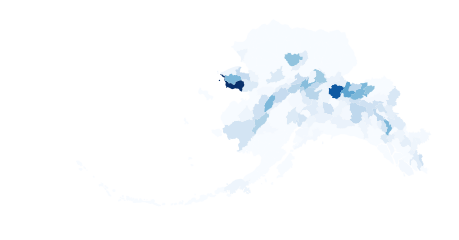

In [27]:
fig, ax = subplots(1,1,figsize=(7,7))
ax = watersheds.plot(column='n_mines', cmap='Blues', ax=ax, linewidth=0.2)
ax.set_axis_off()
foo = ax.axes.set_aspect('equal')

Find the mean area of mining footprints intersecting each watershed.

In [28]:
for wat in watersheds.id_numeric:
    mines_wat = mines[mines[wat]]
    avg_m_area = mines_wat.Shape_Area.mean() * 1e-6
    watersheds.loc[watersheds.id_numeric==wat, 'avg_m_area'] = avg_m_area

In [29]:
watersheds.avg_m_area = watersheds.avg_m_area.fillna(0)

Find the area of mining footprints within watershed boundaires, then find the density = ($\frac{mining\,footprint\,area}{watershed\,area}$).

In [30]:
for wat in watersheds.id_numeric:
    mines_wat = mines[mines[wat]]
    mines_union = mines_wat.unary_union
    watersheds_union = watersheds.query("id_numeric==@wat").unary_union
    mines_reg_clip = mines_union.intersection(watersheds_union)
    watersheds.loc[watersheds.id_numeric==wat, 'area_mines'] = mines_reg_clip.area * 1e-6

In [31]:
watersheds['density_mines'] = watersheds.area_mines/(watersheds.area * 1e-6)

Finally, I'll export the results to shapefile and csv formats.

In [32]:
watersheds.to_file(outfp('Watersheds_with_Mines.shp'))
watersheds.drop('geometry', axis='columns').to_csv(outfp('Watersheds_with_Mines.csv'))